In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_rate, service_rate)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return grocery_store

In [6]:
# Run a short test
grocery_store = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
print(f'There are {grocery_store.queue.people_in_queue} people in the queue')

There are 6 people in the queue


In [7]:
#run 100 times with arrival rate = 0.8, service rate = 1
list_number_in_queue1 = []
for i in range(100):
    grocery_store = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    list_number_in_queue1.append(grocery_store.queue.people_in_queue)

<function matplotlib.pyplot.show(*args, **kw)>

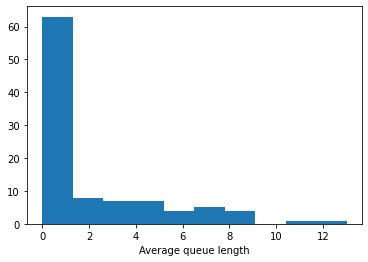

In [36]:
#graph the histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
plt.hist(list_number_in_queue1)
plt.xlabel('Average queue length')
plt.show

In [22]:
#compute mean queue length and 95% CI
mean_queue1 = np.mean(list_number_in_queue1) 
t = sts.sem(list_number_in_queue1) #calculate standard error
print('The sample mean is', mean_queue1)
print('95% confidence interval of the population mean is', [mean_queue1 - 1.96*t, mean_queue1+1.96*t])

The sample mean is 2.03
95% confidence interval of the population mean is [1.4697413425637018, 2.590258657436298]


The sample mean is 1.529
95% confidence interval of the population mean is [1.387033134128398, 1.670966865871602]


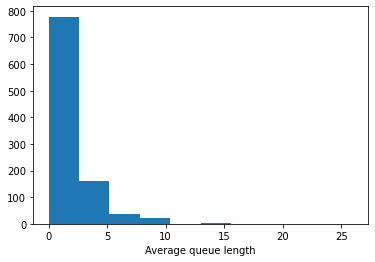

In [35]:
#second experiment: 1000 trials
list_number_in_queue2 = []
for i in range(1000):
    grocery_store = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    list_number_in_queue2.append(grocery_store.queue.people_in_queue)
plt.hist(list_number_in_queue2)
plt.xlabel('Average queue length')
mean_queue2 = np.mean(list_number_in_queue2) 
t2 = sts.sem(list_number_in_queue2) 
print('The sample mean is', mean_queue2)
print('95% confidence interval of the population mean is', [mean_queue2 - 1.96*t2, mean_queue2+1.96*t2])

#comments

The distribution over queue length certainly changed - we see that the one with 1000 trials is a lot more concentration towards 0 (less spread out) than the one with 100 trials. This makes sense because we are having the arrival rate to be lower than the service rate, which means service is faster than arrival, so the queue length should not be long.

Similarly, the average queue length estimate changed from around 2 to 1.4, a 30% decrease. This makes sense due to reasons stated above.

The confidence interval also narrowed - this is intuitive, since we have more data with 1000 trials and we can be fairly more certain than the case with 100 trials, so the range of estimation is narrower.

The sample mean is 7.28
95% confidence interval of the population mean is [6.919352237538386, 7.640647762461614]


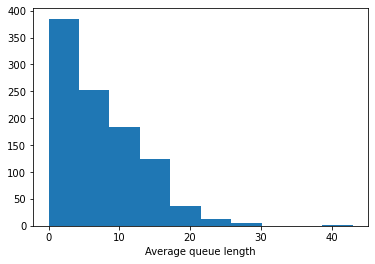

In [34]:
#try with arrival rate of 1 and service rate of 1 for 1000 trials
list_number_in_queue3 = []
for i in range(1000):
    grocery_store = run_simulation(arrival_rate=1, service_rate=1, run_until=100)
    list_number_in_queue3.append(grocery_store.queue.people_in_queue)
plt.hist(list_number_in_queue3)
plt.xlabel('Average queue length')
mean_queue3 = np.mean(list_number_in_queue3) 
t3 = sts.sem(list_number_in_queue3) 
print('The sample mean is', mean_queue3)
print('95% confidence interval of the population mean is', [mean_queue3 - 1.96*t3, mean_queue3+1.96*t3])


The sample mean is 5.076
95% confidence interval of the population mean is [4.754278270877783, 5.397721729122217]


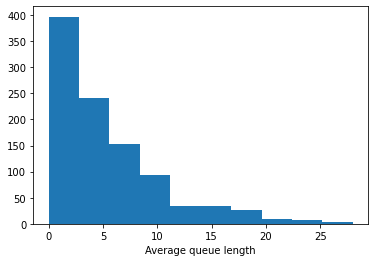

In [33]:
#try with arrival rate of 0.95 and service rate of 1 for 1000 trials
list_number_in_queue4 = []
for i in range(1000):
    grocery_store = run_simulation(arrival_rate=0.95, service_rate=1, run_until=100)
    list_number_in_queue4.append(grocery_store.queue.people_in_queue)
plt.hist(list_number_in_queue4)
plt.xlabel('Average queue length')
mean_queue4 = np.mean(list_number_in_queue4) 
t4 = sts.sem(list_number_in_queue4) 
print('The sample mean is', mean_queue4)
print('95% confidence interval of the population mean is', [mean_queue4 - 1.96*t4, mean_queue4+1.96*t4])

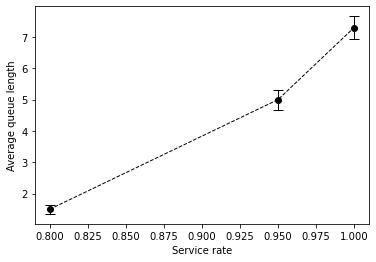

In [37]:
#make the error plot of average queue length
x = [0.8, 0.95, 1] #the value of arrival rate
y = [1.5, 5, 7.3] #value of average queue length
y_error=[0.15,0.32,0.36] #value of the error

plt.figure()
plt.errorbar(x,y,y_error, color='black', marker='o', capsize = 5, linestyle='--', linewidth=1) 
plt.xlabel('Service rate')
plt.ylabel('Average queue length')
plt.show()

It seems with an arrival rate of around 0.95, the average queue length will start to exceed 5!

#Reflection

For #EmpiricalAnalysis, the simulations are done correctly with correct choice of statistics (confidence intervals, sample mean and error) proper graphs showing the results, as well as comments interpreting and explaining why the results make sense (For example, why the confidence interval narrows down when the number of trials increases). I have also run the simulation with 3 different parameters to compare and answer the prompt (queue length starts to exceed 5 when the arrival rate is greater than 0.95). An error plot is also included to compare the results of the simulation.

For #professionalism, I have properly labeled the axes, chosen the best type of graph and made it as clear and simple as possible. I also produced a well-organized Python notebook and following all presentation guidelines, including detailed in-line code comments to guide readers. I also produced a well-written explanation and comment on my simulation results. Finally, the pre-class work is completed well before class and uploaded onto the right platform to present in class (github).